# Time Series Analysis Project : Forecast Post-Sale Customer Service Calls

**`Study of model type`**

## **`Data Collection`**

In [26]:
#import the needed libraries
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

In [27]:
#import the dataset
file="./Service Clients Darty 2017-2021.xlsx"
df = pd.read_excel(file)
df.drop(columns=['Appels EGP'],inplace=True)
df.set_index('Date',inplace=True)
df.head(),df.tail()

(            Appels
 Date              
 2017-01-01     0.0
 2017-01-02  5774.0
 2017-01-03  5744.0
 2017-01-04  5833.0
 2017-01-05  5588.0,
             Appels
 Date              
 2021-12-27     NaN
 2021-12-28     NaN
 2021-12-29     NaN
 2021-12-30     NaN
 2021-12-31     NaN)

In [28]:
df.describe() 

,Appels
count,1734.000000
mean,5461.132065
std,2635.572188
min,0.000000
25%,4211.750000
50%,5804.500000
75%,6899.750000
max,16049.000000


**Split the data (first 3 years)**


In [29]:
train_df = df[df.index<'2020-01-01']
test_df = df[df.index>='2020-01-01']
train_df.tail(),test_df.head()

(            Appels
 Date              
 2019-12-27  5968.0
 2019-12-28  3952.0
 2019-12-29   868.0
 2019-12-30  5520.0
 2019-12-31  4051.0,
             Appels
 Date              
 2020-01-01     0.0
 2020-01-02  5979.0
 2020-01-03  5690.0
 2020-01-04  3834.0
 2020-01-05   687.0)

## **`Useful Functions`**

In [30]:
def resample_df(df, freq):
    """
    Resample a dataframe to a given frequency
    args: 
    - df: dataframe to resample
    - freq: string that gives the frequency ie. 'Y','W','M'
    
    returns: resampled dataframe
    """
    return df.resample(freq).sum()

In [31]:
def selectPeriod(df,period):
    """
    Select a periodicity of a dataframe
    args: 
    - df: dataframe studied
    
    returns: periodicity studied
    """
    if period == 'Y':
        return df.index.year
    elif period == 'M':
        return df.index.month
    elif period == 'W':
        return df.index.isocalendar().week


In [32]:
def selectSeason(df,season):
    """
    Select a season of a dataframe
    args: 
    - df: dataframe studied
    
    returns: season studied
    """
    if season == 'M':
        return df.index.month
    elif season == 'W':
        return df.index.isocalendar().week
    elif season == 'WD':
        return df.index.weekday
    elif season == 'D':
        return df.index.day_of_year

In [33]:
def createWeekMonthDF(df,year,period_chosen = "W"):
    """
    Transform a df into a df that have the weekly number of calls for each months
    args: 
    - df: dataframe to work on
    
    returns: formatted df
    """
    
    df_created = df[df.index.year==year]
    df_created = resample_df(df_created,period_chosen)
    df_created["Month"]=df_created.index.month
    df_created.reset_index(inplace=True)
    df_created.drop(columns=['Date'],inplace=True)
    df_created.set_index('Month',inplace=True)

    return df_created

In [34]:
def monthWeekBBT(df,years=[],period_chosen="W"):
    """
    Transform a df into a buys monthly/week ballot table
    args: 
    - df: dataframe to resample
    
    returns: formatted df
    """
    
    df_bbt = pd.DataFrame()
    for year in years:
        df_studied = createWeekMonthDF(df,year,period_chosen)
        dic_year = {}
        for i in range(1,13):
            listWeeks_i = df_studied[df_studied.index==i]['Appels'].values
            if listWeeks_i.shape < (5,): #Add 0 when the month haven't 5 weeks
                listWeeks_i = np.append(listWeeks_i,np.nan)
            dic_year[i]=listWeeks_i.tolist()
        df_bbt = pd.concat([df_bbt,pd.DataFrame(dic_year).T])
    return df_bbt

In [35]:
def yearBBT(df,season='M'):
    """
    Transform a df into a buys year/season ballot table
    args: 
    - df: dataframe to resample
    - season: string to inform the season
    
    returns: formatted df
    """
    df_buysBallot = pd.DataFrame()
    selected_period = selectPeriod(df,"Y")
    periods = set(selected_period)
    for period in periods:
        period_condition = selected_period == period
        selected_season = selectSeason(df[period_condition],season)
        df_buysBallot[str(period)] = df[period_condition].groupby(selected_season).sum()
    df_buysBallot=df_buysBallot.T

    return df_buysBallot
    

In [36]:
def getBuysBallot(df,period='Y',season='M'):
    """
    Transform a df into a buys ballot table
    args: 
    - df: dataframe to resample
    - period: string that gives the period studied
    - season: string that gives the season
    returns: formatted df
    """

    if period=='Y':
        return yearBBT(df,season="M")
    if period=="M":
        years=list(df.index.year.unique())
        return monthWeekBBT(df,years)

In [37]:
def compute_mean(df,period='Y',season='M'):
    """
    Compute the mean of a dataframe
    args: 
    - df: dataframe to resample
    - period: string that gives the period ie. 'Y','W','M'
    - season: string that gives the season ie. 'Y','W','M'
    
    returns: mean of the dataframe
    """
    df = getBuysBallot(df,period,season)
    return df.mean(axis=0)                 
    


In [38]:
def compute_std(df,period='Y',season='M'):
    """
    Compute the standard deviation of a dataframe
    args: 
    - df: dataframe to resample
    - period: string that gives the period ie. 'Y','W','M'
    - season: string that gives the season ie. 'Y','W','M'
    
    returns: standard deviation of the dataframe
    """
    df = getBuysBallot(df,period,season)
    return df.std(axis=0)

In [39]:
def plot_decomposition_type(mean_df,std_df):
    """
    Relationship between the seasonal means and the seasonal standard deviations
    args: 
    - mean_df: dataframe with means values
    - std_df: dataframe with std values
    
    returns: plot of the seasonal means and the pooled standard deviations
    """

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=mean_df.index, y=mean_df,name="Seasonal mean",line = dict(color='black', width=2)))
    fig.add_trace(go.Scatter(x=mean_df.index, y=std_df,name="Seasonal standard deviation",line = dict(color='black', width=1, dash='dash')))
    fig.update_layout(title='Relationship between the seasonal means and the seasonal pooled standard deviations',
                    xaxis_title='Period',
                    yaxis_title='NUmber of calls')

    fig.show()

## **`Results for model type`**

### **`Period: Year & Season: Month`**

In [40]:
bbt_YM=getBuysBallot(train_df,"Y","M")
bbt_YM

Date,1,2,3,4,5,6,7,8,9,10,11,12
2017,163082.0,140966.0,141573.0,114999.0,130337.0,152602.0,193753.0,179083.0,178460.0,165064.0,188319.0,221464.0
2018,173209.0,160203.0,160186.0,142896.0,127959.0,138021.0,166649.0,151997.0,144416.0,150877.0,194987.0,171215.0
2019,169980.0,134671.0,117593.0,115688.0,126345.0,139291.0,186758.0,149692.0,142779.0,144144.0,144316.0,211975.0


In [41]:
mean_df = compute_mean(train_df,"Y","M")
std_df = compute_std(train_df,"Y","M")

plot_decomposition_type(mean_df,std_df)
std_df.corr(mean_df)

0.49294984342916687

### **`Period: Year & Season: Week`**

In [42]:
bbt_YW=getBuysBallot(train_df,"Y","W")
bbt_YW

Date,1,2,3,4,5,6,7,8,9,10,11,12
2017,163082.0,140966.0,141573.0,114999.0,130337.0,152602.0,193753.0,179083.0,178460.0,165064.0,188319.0,221464.0
2018,173209.0,160203.0,160186.0,142896.0,127959.0,138021.0,166649.0,151997.0,144416.0,150877.0,194987.0,171215.0
2019,169980.0,134671.0,117593.0,115688.0,126345.0,139291.0,186758.0,149692.0,142779.0,144144.0,144316.0,211975.0


In [43]:
mean_df = compute_mean(train_df,"Y","W")
std_df = compute_std(train_df,"Y","W")

plot_decomposition_type(mean_df,std_df)
std_df.corr(mean_df)

0.49294984342916687

### **`Period: Year & Season: Day`**

In [44]:
bbt_YD=getBuysBallot(train_df,"Y","D")
bbt_YD

Date,1,2,3,4,5,6,7,8,9,10,11,12
2017,163082.0,140966.0,141573.0,114999.0,130337.0,152602.0,193753.0,179083.0,178460.0,165064.0,188319.0,221464.0
2018,173209.0,160203.0,160186.0,142896.0,127959.0,138021.0,166649.0,151997.0,144416.0,150877.0,194987.0,171215.0
2019,169980.0,134671.0,117593.0,115688.0,126345.0,139291.0,186758.0,149692.0,142779.0,144144.0,144316.0,211975.0


In [45]:
mean_df = compute_mean(train_df,"Y","D")
std_df = compute_std(train_df,"Y","D")

plot_decomposition_type(mean_df,std_df)
std_df.corr(mean_df)

0.49294984342916687

### **`Period: Month & Season: Week`**

In [46]:
train_df

,Appels
Date,
2017-01-01,0.0
2017-01-02,5774.0
2017-01-03,5744.0
2017-01-04,5833.0
2017-01-05,5588.0
...,...
2019-12-27,5968.0
2019-12-28,3952.0
2019-12-29,868.0


In [47]:
bbt_MW = getBuysBallot(train_df,"M")

In [48]:
mean_df = compute_mean(train_df,"M","W")
std_df = compute_std(train_df,"M","W")

plot_decomposition_type(mean_df,std_df)
std_df.corr(mean_df)

-0.7507081881361909

### **`Period: Month & Season: Day`**

### **`Correlation`**

In [49]:
corr_dic = {}
corr_df = pd.DataFrame()

for period in ['Y','M','W']:
    for season in ['M','W','WD','D']:
        mean_df = compute_mean(train_df,period,season)
        std_df = compute_std(train_df,period,season)
        corr_dic[f"P:{period}&S:{season}"] = std_df.corr(mean_df)

for key in corr_dic.keys():
    corr_df[key] = [corr_dic[key]]
corr_df.rename(index={0: 'correlation'},inplace=True)
corr_df

AttributeError: 'NoneType' object has no attribute 'mean'

## **`Study Seasonal Components`**

### **`Plot the data`**

In [50]:
train_df_weekly = train_df.resample('W').sum()
train_df_monthly = train_df.resample('M').sum()

Text(0.5, 1.0, 'Monthly')

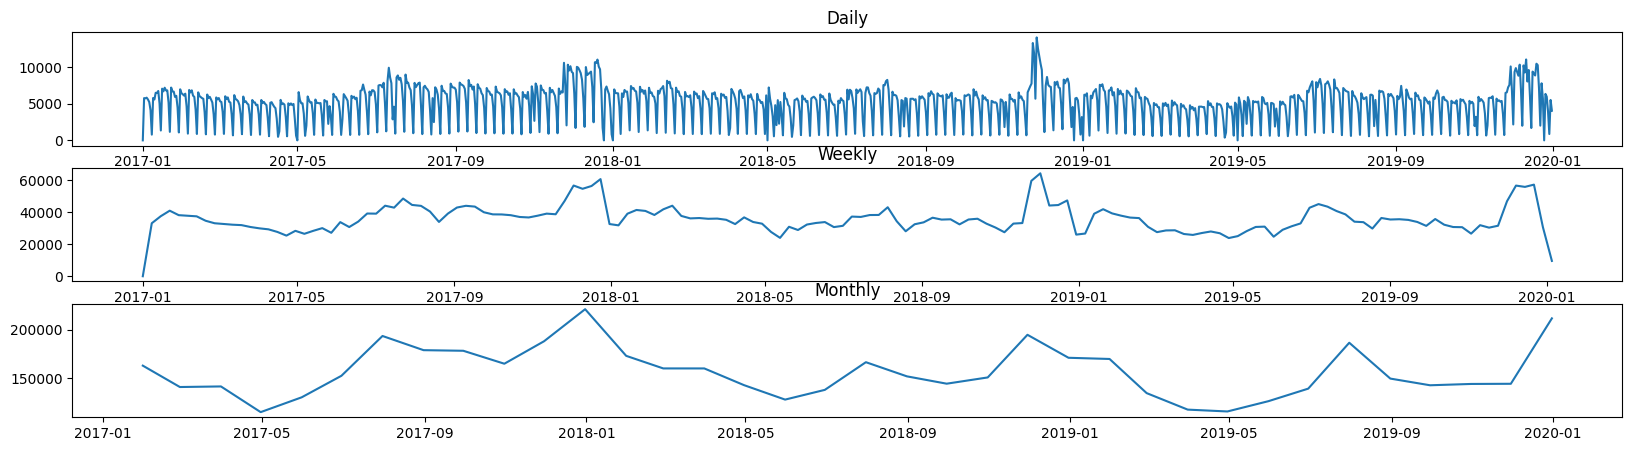

In [51]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,5))

ax1.plot(train_df.index,train_df['Appels'])
ax1.set_title('Daily')
ax2.plot(train_df_weekly.index,train_df_weekly['Appels'])
ax2.set_title('Weekly')
ax3.plot(train_df_monthly.index,train_df_monthly['Appels'])
ax3.set_title('Monthly')



### **`Sorted Buys Ballot Table`**

In [52]:
bbt_YM

Date,1,2,3,4,5,6,7,8,9,10,11,12
2017,163082.0,140966.0,141573.0,114999.0,130337.0,152602.0,193753.0,179083.0,178460.0,165064.0,188319.0,221464.0
2018,173209.0,160203.0,160186.0,142896.0,127959.0,138021.0,166649.0,151997.0,144416.0,150877.0,194987.0,171215.0
2019,169980.0,134671.0,117593.0,115688.0,126345.0,139291.0,186758.0,149692.0,142779.0,144144.0,144316.0,211975.0


In [53]:
list_bbt_YM = []
for i in range(len(bbt_YM)):
    list_bbt_YM.append(bbt_MW.iloc[i].values)
    
sort_index = np.argsort(list_bbt_YM)
sort_index


array([[0, 1, 2, 4, 3],
       [3, 2, 1, 0, 4],
       [3, 2, 1, 0, 4]])

In [54]:
sorted_bbt = pd.DataFrame()
for i in range(len(sort_index)):
    sorted_bbt[i] = sort_index[i]
sorted_bbt.T

,0,1,2,3,4
0,0,1,2,4,3
1,3,2,1,0,4
2,3,2,1,0,4


In [55]:
list_bbt_YW = []
for i in range(len(bbt_YW)):
    list_bbt_YW.append(bbt_YW.iloc[i].values)
    
sort_index = np.argsort(list_bbt_YW)

sorted_bbt = pd.DataFrame()
for i in range(len(sort_index)):
    sorted_bbt[i] = sort_index[i]
sorted_bbt.T

,0,1,2,3,4,5,6,7,8,9,10,11
0,3,4,1,2,5,0,9,8,7,10,6,11
1,4,5,3,8,9,7,2,1,6,11,0,10
2,3,2,4,1,5,8,9,10,7,0,6,11


# **`Archives`**

In [56]:
def getBuysBallot(df,period='Y',season='M'):
    """
    Transform a df into a buys ballot table
    args: 
    - df: dataframe to resample
    
    returns: formatted df
    """

    
    df_buysBallot = pd.DataFrame()
    selected_period = selectPeriod(df,period)
    periods = set(selected_period)
    for period in periods:
        period_condition = selected_period == period
        selected_season = selectSeason(df[period_condition],season)
        df_buysBallot[str(period)] = df[period_condition].groupby(selected_season).sum()
    df_buysBallot=df_buysBallot.T
    
    return df_buysBallot